In [110]:
import networkx as nx
import seaborn
import custom_funcs as cf
import matplotlib.pyplot as plt
import numpy as np

from joblib import Parallel, delayed
from time import time

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
# Set Seaborn styles & context
seaborn.set_context("paper")
seaborn.set_style('white')

In [130]:
# Read in data and do data pre-processing
G = nx.read_gpickle('20150902_all_ird Final Graph.pkl')
G = cf.impute_reassortant_status(G)
G = cf.impute_host_group_name(G)
G = cf.impute_weights(G)

In [131]:
# Compute proportion reassortant
data_props = cf.edge_proportion_reassortant(G, attr='host_group', exclusions=['Unknown'])
data_props

{'diff_attr': 0.8457956143244005, 'same_attr': 0.3621090789224779}

In [133]:
start = time()
def null_distribution_proportion_reassortant(G):
    G_shuffled = cf.shuffle_node_attribute_label(G, 'host_group')
    props = cf.edge_proportion_reassortant(G_shuffled, 'host_group', exclusions=['Unknown'])
    return props

props_null = Parallel(n_jobs=-1)(delayed(null_distribution_proportion_reassortant)(G) for i in range(20))
end = time()
print(end - start)

94.68702793121338


In [134]:
null = pd.DataFrame(props_null)
null.mean()

diff_attr    0.442358
same_attr    0.441967
dtype: float64

In [135]:
data = pd.DataFrame([data_props])
data.mean()

diff_attr    0.845796
same_attr    0.362109
dtype: float64

(0, 1)

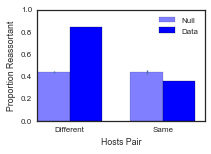

In [136]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(1,1,1)
ind = np.arange(2)
width = 0.35

ax.bar(ind, null.mean(), width, color='blue', label='Null', alpha=0.5, yerr=null.std()*5)
ax.bar(ind+width, data.mean(), width, color='blue', label='Data')
ax.set_xticks(ind+width)
ax.set_xticklabels(['Different', 'Same'])
ax.set_xlabel('Hosts Pair')
ax.set_ylabel('Proportion Reassortant')
ax.legend()
ax.set_ylim(0,1)

In [170]:
# Between which host groups are they over-represented or under-represented?

def host_group_domain_graph(G):
    """
    Computes the proportion of reassortant representation when crossing between host groups.
    """
    hg_graph = nx.DiGraph()

    for n, node_d in G.nodes(data=True):

        in_edges = G.in_edges(n, data=True)
        total_edges = len(in_edges)
        is_reassortant = node_d['reassortant']

        sk_hg = G.node[n]['host_group']
        if sk_hg not in hg_graph.nodes():
            hg_graph.add_node(sk_hg)

        for sc, _, edge_d in in_edges:
            sc_hg = G.node[sc]['host_group']
            if sc_hg not in hg_graph.nodes():
                hg_graph.add_node(sc_hg)

            if (sc_hg, sk_hg) not in hg_graph.edges():
                hg_graph.add_edge(sc_hg, sk_hg, total=edge_d['weight'], reassortant=0)
            if (sc_hg, sk_hg) in hg_graph.edges():
                hg_graph.edge[sc_hg][sk_hg]['total'] += edge_d['weight']

            if is_reassortant:
                hg_graph.edge[sc_hg][sk_hg]['reassortant'] += edge_d['weight']

    for sc, sk, d in hg_graph.edges(data=True):
        hg_graph.edge[sc][sk]['p_reassortant'] = d['reassortant'] / d['total']
        
    return hg_graph


In [171]:
hg_graph = host_group_domain_graph(G)
hg_graph.edges(data=True)

[('Domestic',
  'Domestic',
  {'p_reassortant': 0.3804251591876072,
   'reassortant': 1371.3913753040933,
   'total': 3604.8913753040965}),
 ('Domestic',
  'Unknown',
  {'p_reassortant': 0.6601869032518655,
   'reassortant': 97.24764150943463,
   'total': 147.3031970649894}),
 ('Domestic',
  'Human',
  {'p_reassortant': 0.9068832717419104,
   'reassortant': 311.65468588315395,
   'total': 343.6546858831548}),
 ('Domestic',
  'Wild',
  {'p_reassortant': 0.5841687228735277,
   'reassortant': 176.53923649449953,
   'total': 302.20590316116636}),
 ('Unknown',
  'Domestic',
  {'p_reassortant': 0.5942138441211114,
   'reassortant': 71.7768756627754,
   'total': 120.79300469503363}),
 ('Unknown',
  'Unknown',
  {'p_reassortant': 0.35186830415469034,
   'reassortant': 31.75943396226415,
   'total': 90.25943396226415}),
 ('Unknown',
  'Human',
  {'p_reassortant': 0.8145589026000963,
   'reassortant': 30.753902341611095,
   'total': 37.75528355708067}),
 ('Unknown',
  'Wild',
  {'p_reassortant':

In [249]:
def null_proportion_hg_reassortant(G, equally=False):
    
    G_shuffled = cf.shuffle_node_attribute_label(G, 'host_group', equally)
    hg_graph_shuf = host_group_domain_graph(G_shuffled)
    
    return hg_graph_shuf

In [263]:
start = time()
results = Parallel(n_jobs=-1)(delayed(null_proportion_hg_reassortant)(G, equally=True) for i in range(100))
len(results)
end = time()
print(end - start)

702.4990861415863


In [264]:
def distr_null_p_reassortant(list_of_hg_graphs):
    hg_graph = nx.DiGraph()
    for g in list_of_hg_graphs:
        hg_graph.add_nodes_from(g.nodes())
        for sc, sk, d in g.edges(data=True):
            if (sc, sk) not in hg_graph.edges():
                hg_graph.add_edge(sc, sk, p_reassortant=[d['p_reassortant']])
            else:
                hg_graph.edge[sc][sk]['p_reassortant'].append(d['p_reassortant'])
    return hg_graph

summaryG = distr_null_p_reassortant(results)

In [265]:
summaryG.edges(data=True)

[('Unknown',
  'Unknown',
  {'p_reassortant': [0.43696911044395875,
    0.4355835007307221,
    0.4208341990361889,
    0.4230384532034962,
    0.4370442120308615,
    0.4142665861960521,
    0.4288829520404477,
    0.42927430564315644,
    0.4400302425680679,
    0.4059336813154442,
    0.4018285118348971,
    0.40440174745020435,
    0.43170843827358585,
    0.43988499148253973,
    0.42894049683852414,
    0.4516687803515658,
    0.4127353136646978,
    0.4472026924365954,
    0.42897424539783435,
    0.4563297184659833,
    0.4165200127157205,
    0.44658739391731855,
    0.44831183725758283,
    0.42518260633306104,
    0.4231492560848256,
    0.4521729130634768,
    0.4529666876972418,
    0.4215660043230345,
    0.4441881648497741,
    0.41145144253410587,
    0.43401446891016193,
    0.42211214741128095,
    0.46464178818860086,
    0.4324510814070436,
    0.4408500715316113,
    0.4283156744101509,
    0.43998073343962246,
    0.4631847352350446,
    0.4365591948702144,
    0.

In [266]:
name_map = {'Wild':'W',
            'Domestic':'D',
            'Human':'H'}
names = []
means = []
stds  = []
for sc, sk, d in summaryG.edges(data=True):
    if sc == 'Unknown' or sk == 'Unknown':
        pass
    else:
        mean = np.mean(d['p_reassortant'])
        std = np.std(d['p_reassortant'])
        
        names.append('{0}:{1}'.format(name_map[sc], name_map[sk]))
        means.append(mean)
        stds.append(std)

In [267]:
data = []

for sc, sk, d in hg_graph.edges(data=True):
    if sc == 'Unknown' or sk == 'Unknown':
        pass
    else:
        data.append(d['p_reassortant'])
data

[0.3804251591876072,
 0.9068832717419104,
 0.5841687228735277,
 0.7294682885810697,
 0.2965382885423946,
 0.9641486255758752,
 0.7641850226081182,
 0.9882945270989435,
 0.49974924793690073]

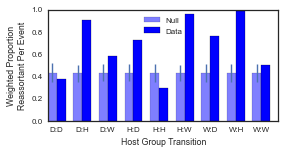

In [279]:
fig = plt.figure(figsize=(4,2))

ind = np.arange(len(means))
width = 0.35

ax = fig.add_subplot(1,1,1)
ax.bar(ind, means, width=width, color='blue', label='Null', yerr=np.array(stds)*5, alpha=0.5)
ax.bar(ind+width, data, width=width, color='blue', label='Data')
ax.set_xticks(ind+width)
ax.set_xticklabels(names)
ax.set_ylabel('Weighted Proportion\nReassortant Per Event')
ax.set_xlabel('Host Group Transition')
ax.legend(loc='upper center')
plt.subplots_adjust(left=0.15, right=0.95)
plt.savefig('Figure 2.pdf')
plt.show()

In [274]:
np.array(means) - np.array(data)

array([ 0.05333104, -0.4767556 , -0.14965754, -0.29672359,  0.1340915 ,
       -0.53273047, -0.33293242, -0.55757043, -0.0677194 ])